In [1]:
import pandas as pd
import numpy as np
import math as m
from datetime import datetime
import matplotlib.pyplot as plt
%matplotlib inline 

In [2]:
data = pd.read_csv('forLearning2016.csv')

In [3]:
len(data.ix[data['soldPrice']>10**7])

11

In [4]:
data.head()

,id,beds,baths,sqft,sqftlot,built,soldPrice,lat,lon,sqftRatio,zip,street,yOld,soldOnDate
0,1,4,2,1650,3162,1956,880000,37.693868,-122.495487,1.916364,94015,Skyline-Dr-Daly-City,60,2015-10-09
1,2,3,2,1200,3528,1958,825000,37.693259,-122.495785,2.940000,94015,Roslyn-Ct-Daly-City,58,2015-09-03
2,3,2,1,1220,3800,1953,850000,37.699788,-122.494274,3.114754,94015,Glenwood-Ave-Daly-City,63,2015-07-02
3,4,2,1,1050,3162,1956,711000,37.693603,-122.495372,3.011429,94015,Skyline-Dr-Daly-City,60,2014-11-07
4,5,4,2,1690,3301,1954,767000,37.695735,-122.494190,1.953254,94015,S-Mayfair-Ave-Daly-City,62,2014-10-31


In [5]:
X = data[['beds','baths','sqft', 'sqftlot','yOld','sqftRatio', 'soldOnDate']]
X.head()

,beds,baths,sqft,sqftlot,yOld,sqftRatio,soldOnDate
0,4,2,1650,3162,60,1.916364,2015-10-09
1,3,2,1200,3528,58,2.940000,2015-09-03
2,2,1,1220,3800,63,3.114754,2015-07-02
3,2,1,1050,3162,60,3.011429,2014-11-07
4,4,2,1690,3301,62,1.953254,2014-10-31


In [6]:
y = data['soldPrice']
y.head()

0    880000
1    825000
2    850000
3    711000
4    767000
Name: soldPrice, dtype: float64

## Turn date to days from January 1th, 2016

In [7]:
x = data['soldOnDate'].apply(lambda x:  (np.datetime64('2016-01-01')-np.datetime64(x)).astype(int))

In [8]:
X['soldOnDate'] = x

/home/pavel/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [9]:
X.head()

,beds,baths,sqft,sqftlot,yOld,sqftRatio,soldOnDate
0,4,2,1650,3162,60,1.916364,84
1,3,2,1200,3528,58,2.940000,120
2,2,1,1220,3800,63,3.114754,183
3,2,1,1050,3162,60,3.011429,420
4,4,2,1690,3301,62,1.953254,427


## Making test-train partitions

In [10]:
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=42)

In [11]:
len(X_test)

790

## Dealing with NA

In [12]:
from sklearn.preprocessing import Imputer
imp = Imputer(strategy = 'median')
X_train_imp =imp.fit_transform(X_train)
X_test_imp = imp.transform(X_test)

## Normalization

In [13]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_imp)
X_test_scaled = scaler.transform(X_test_imp)

## Cross-validation preparation

In [14]:
from sklearn.cross_validation import KFold
cv = KFold(n_folds= 10,random_state=42, shuffle = True, n = len(y_train))

## Baseline with mean and median

In [15]:
meanPrice = y.mean()
medianPrice = y.median()
print 'Mean price is ',meanPrice
print 'Median price is ',medianPrice

Mean price is  1118637.27596
Median price is  875000.0


In [16]:
rmse = m.sqrt(np.mean((meanPrice-y_train)**2))
mae = np.median(np.abs(medianPrice-y_train))
print 'RMSE is ', rmse
print 'MAE for MEDIAN', mae
print 'mae/median', mae/np.median(y)

RMSE is  1472250.3628
MAE for MEDIAN 275000.0
mae/median 0.314285714286


# kNN regressor

In [17]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import *

In [18]:
rgr = KNeighborsRegressor()
param_grid = {
    "n_neighbors": range(1,40,2),
    "p" : [1,1.2,1.5,1.7,2,2.2]
    }

In [19]:
grid_search = GridSearchCV(rgr, param_grid=param_grid, n_jobs = 3,cv = cv, scoring='median_absolute_error')
grid_search.fit(X_train_scaled, y_train)

GridSearchCV(cv=sklearn.cross_validation.KFold(n=7106, n_folds=10, shuffle=True, random_state=42),
       error_score='raise',
       estimator=KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=5, p=2,
          weights='uniform'),
       fit_params={}, iid=True, n_jobs=3,
       param_grid={'n_neighbors': [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33, 35, 37, 39], 'p': [1, 1.2, 1.5, 1.7, 2, 2.2]},
       pre_dispatch='2*n_jobs', refit=True,
       scoring='median_absolute_error', verbose=0)

In [20]:
grid_search.best_estimator_

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=29, p=1,
          weights='uniform')

In [21]:
grid_search.best_score_

-221406.57620563495

In [22]:
-grid_search.score(X_test_scaled,y_test)

/home/pavel/anaconda/lib/python2.7/site-packages/sklearn/grid_search.py:418: ChangedBehaviorWarning: The long-standing behavior to use the estimator's score function in GridSearchCV.score has changed. The scoring parameter is now used.
  ChangedBehaviorWarning)


217517.24137931038

In [23]:
-grid_search.score(X_test_scaled,y_test)/np.median(y)

0.24859113300492613

In [24]:
knn_results = pd.DataFrame(index=np.arange(0, 3),columns = ['n_neighbors','p','mae'])
k=0
for i in grid_search.grid_scores_:
    knn_results.loc[k]=[i[0]['n_neighbors'],i[0]['p'],-i[1]]
    k = k+1 

/home/pavel/anaconda/lib/python2.7/site-packages/matplotlib/figure.py:387: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


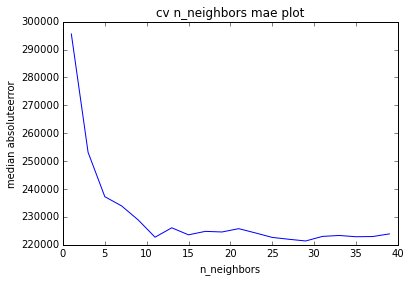

In [25]:
fig = plt.figure()
ax = fig.add_subplot(111)
slc = knn_results[knn_results['p']==1]
x_points = slc['n_neighbors']
y_points = slc['mae']
p = ax.plot(x_points, y_points, 'b')
ax.set_xlabel('n_neighbors')
ax.set_ylabel('median absoluteerror')
ax.set_title('cv n_neighbors mae plot')
fig.show()

# Linear Regression

In [26]:
from sklearn import linear_model
from sklearn.cross_validation import cross_val_score

In [27]:
#rgr = linear_model.LinearRegression(fit_intercept=True)
#scores = cross_val_score(estimator =rgr,X =X_train_scaled,y = y_train, n_jobs = 3,cv = cv, scoring='median_absolute_error')
#print -np.mean(scores)/np.median(y)
#print -np.mean(scores)
rgr = linear_model.LinearRegression(fit_intercept=True)
#scores = cross_val_score(estimator =rgr,X =X_train_scaled,y = y_train, n_jobs = 3,cv = cv, scoring='median_absolute_error')
#print -np.mean(scores)/np.median(y)
#print -np.mean(scores)
rgr.fit(X =X_train_scaled,y = y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [28]:
from sklearn.metrics import median_absolute_error
print median_absolute_error(rgr.predict(X_test_scaled), y_test)

267385.264882


# Ridge Regression

In [29]:
rgr = linear_model.Ridge()
param_grid = {
    "alpha": np.linspace(0.001,1,20)
    }
grid_search = GridSearchCV(rgr, param_grid=param_grid, n_jobs = 3,cv = cv, scoring='median_absolute_error')
grid_search.fit(X_train_scaled, y_train)
print grid_search.best_estimator_
print -grid_search.best_score_
print -grid_search.score(X_test_scaled,y_test)/np.median(y)

Ridge(alpha=0.001, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)
266135.8
0.305583032897


# LOOCV Ridge Regression

In [30]:
rgr = linear_model.RidgeCV(alphas=np.linspace(0.001,1,20),scoring='median_absolute_error',store_cv_values= True)
a =rgr.fit(X_train_scaled, y_train)

In [31]:
print a.alpha_
print np.median(np.abs((rgr.predict(X_test_scaled)-y_test)))/np.median(y)

0.474210526316
0.305486185143


# Lasso Regression

In [32]:
rgr = linear_model.Lasso()
param_grid = {
    "alpha": np.linspace(0.0001,1,200)
    }
grid_search = GridSearchCV(rgr, param_grid=param_grid, n_jobs = 3,cv = cv, scoring='median_absolute_error')
grid_search.fit(X_train_scaled, y_train)
print grid_search.best_estimator_
print -grid_search.best_score_
print -grid_search.score(X_test_scaled,y_test)/np.median(y)

Lasso(alpha=0.0001, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)
266135.784596
0.305583159545


# Support Vector Regression

In [33]:
from sklearn.svm import SVR

In [34]:
rgr = SVR()
param_grid = {
    "kernel": ['linear','rbf','poly','sigmoid'],
    #"C" : [0.1,0.5,1,1.5]
    #"C" : [1,1.5,2,3]
    "C" : [3,4,5,10]
    }

In [35]:
grid_search = GridSearchCV(rgr, param_grid=param_grid, n_jobs = 3,cv = cv, scoring='median_absolute_error')
grid_search.fit(X_train_scaled, y_train)

GridSearchCV(cv=sklearn.cross_validation.KFold(n=7106, n_folds=10, shuffle=True, random_state=42),
       error_score='raise',
       estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False),
       fit_params={}, iid=True, n_jobs=3,
       param_grid={'kernel': ['linear', 'rbf', 'poly', 'sigmoid'], 'C': [3, 4, 5, 10]},
       pre_dispatch='2*n_jobs', refit=True,
       scoring='median_absolute_error', verbose=0)

In [36]:
print grid_search.best_estimator_
print -grid_search.best_score_
print -grid_search.score(X_test_scaled,y_test)/np.median(y)

SVR(C=10, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='linear', max_iter=-1, shrinking=True, tol=0.001, verbose=False)
264333.060598
0.292965895031


# Random Forest Regressor

In [37]:
from sklearn.ensemble import RandomForestRegressor

In [38]:
rgr = RandomForestRegressor(random_state=42)
param_grid = {
    "n_estimators": [15,16,17,18,19],
    "max_depth": [10,11,12,13,14],
    "min_samples_leaf" : [1,5]  ,
    "max_features": ['auto','sqrt']
    }

In [39]:
grid_search = GridSearchCV(rgr, param_grid=param_grid, n_jobs = 3,cv = cv, scoring='median_absolute_error')
grid_search.fit(X_train_scaled, y_train)

GridSearchCV(cv=sklearn.cross_validation.KFold(n=7106, n_folds=10, shuffle=True, random_state=42),
       error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=42,
           verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=3,
       param_grid={'n_estimators': [15, 16, 17, 18, 19], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 11, 12, 13, 14], 'min_samples_leaf': [1, 5]},
       pre_dispatch='2*n_jobs', refit=True,
       scoring='median_absolute_error', verbose=0)

In [40]:
print grid_search.best_estimator_
print -grid_search.best_score_
print np.median(np.abs(grid_search.predict(X_test_scaled)-y_test))/np.median(y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=12,
           max_features='sqrt', max_leaf_nodes=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=18, n_jobs=1, oob_score=False, random_state=42,
           verbose=0, warm_start=False)
209450.803129
0.238603417187


In [41]:
grid_search.best_estimator_.feature_importances_

array([ 0.05989763,  0.14799154,  0.25750876,  0.12488892,  0.10521356,
        0.132232  ,  0.17226759])

# Extra Trees Regressor

In [42]:
from sklearn.ensemble import ExtraTreesRegressor


In [43]:
rgr = ExtraTreesRegressor(random_state=42)
param_grid = {
    "n_estimators": [13,14,15,16,17],
    "max_depth": [14,15,16,17,18],
    "min_samples_leaf" : [1,5]  ,
    "max_features": ['auto','sqrt']
    }

In [44]:
grid_search = GridSearchCV(rgr, param_grid=param_grid, n_jobs = 3,cv = cv, scoring='median_absolute_error')
grid_search.fit(X_train_scaled, y_train)

GridSearchCV(cv=sklearn.cross_validation.KFold(n=7106, n_folds=10, shuffle=True, random_state=42),
       error_score='raise',
       estimator=ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=None,
          max_features='auto', max_leaf_nodes=None, min_samples_leaf=1,
          min_samples_split=2, min_weight_fraction_leaf=0.0,
          n_estimators=10, n_jobs=1, oob_score=False, random_state=42,
          verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=3,
       param_grid={'n_estimators': [13, 14, 15, 16, 17], 'max_features': ['auto', 'sqrt'], 'max_depth': [14, 15, 16, 17, 18], 'min_samples_leaf': [1, 5]},
       pre_dispatch='2*n_jobs', refit=True,
       scoring='median_absolute_error', verbose=0)

In [45]:
print grid_search.best_estimator_
print -grid_search.best_score_
print np.median(np.abs(grid_search.predict(X_test_scaled)-y_test))/np.median(y)

ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=17,
          max_features='auto', max_leaf_nodes=None, min_samples_leaf=5,
          min_samples_split=2, min_weight_fraction_leaf=0.0,
          n_estimators=17, n_jobs=1, oob_score=False, random_state=42,
          verbose=0, warm_start=False)
214656.444265
0.260119437989


In [46]:
grid_search.best_estimator_.feature_importances_

array([ 0.06363976,  0.14876615,  0.50321177,  0.02966783,  0.07822325,
        0.03815451,  0.13833674])

# Gradient Boosting Regressor

In [47]:
from sklearn.ensemble import GradientBoostingRegressor

In [48]:
rgr = GradientBoostingRegressor(random_state=42)
param_grid = {
    "n_estimators": [15,20,25],
    "max_depth": [5,10,15,20],
    "min_samples_leaf" : [1,5]  ,
    "max_features": ['auto','sqrt'],
    "loss" : ['ls', 'lad', 'huber', 'quantile'],
    "learning_rate" : [0.1,0.5,1]
    }

In [49]:
grid_search = GridSearchCV(rgr, param_grid=param_grid, n_jobs = 3,cv = cv, scoring='median_absolute_error')
grid_search.fit(X_train_scaled, y_train)

GridSearchCV(cv=sklearn.cross_validation.KFold(n=7106, n_folds=10, shuffle=True, random_state=42),
       error_score='raise',
       estimator=GradientBoostingRegressor(alpha=0.9, init=None, learning_rate=0.1, loss='ls',
             max_depth=3, max_features=None, max_leaf_nodes=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=100,
             presort='auto', random_state=42, subsample=1.0, verbose=0,
             warm_start=False),
       fit_params={}, iid=True, n_jobs=3,
       param_grid={'loss': ['ls', 'lad', 'huber', 'quantile'], 'learning_rate': [0.1, 0.5, 1], 'min_samples_leaf': [1, 5], 'n_estimators': [15, 20, 25], 'max_features': ['auto', 'sqrt'], 'max_depth': [5, 10, 15, 20]},
       pre_dispatch='2*n_jobs', refit=True,
       scoring='median_absolute_error', verbose=0)

In [50]:
print grid_search.best_estimator_
print -grid_search.best_score_
print np.median(np.abs(grid_search.predict(X_test_scaled)-y_test))/np.median(y)

GradientBoostingRegressor(alpha=0.9, init=None, learning_rate=0.1, loss='lad',
             max_depth=10, max_features='sqrt', max_leaf_nodes=None,
             min_samples_leaf=5, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=25, presort='auto',
             random_state=42, subsample=1.0, verbose=0, warm_start=False)
195647.476615
0.203810635289


# Multi-layer Preceptron Regressor with 2 ReLu

In [53]:
from sknn.platform import cpu64, threads3

In [54]:
import random
random.seed(42)

In [55]:
import sys
import logging

logging.basicConfig(
            format="%(message)s",
            level=logging.DEBUG,
            stream=sys.stdout)

In [56]:
def rmse(x,y):
    return m.sqrt(np.mean((x-y)**2))
def my_callback(**other):
    a = np.median(np.abs(np.squeeze(nn.predict(X_train_scaled))-y_train))
    #b = np.median(np.abs(np.squeeze(nn.predict(X_train_scaled))-y_train))/np.median(y)
    print "MAE - "+str(a)
    #print "NRMSE percent - " + str(round(rmse(np.squeeze(nn.predict(X_train_scaled)),y_train))/(np.max(y)-np.min(y))

In [57]:
from sknn.mlp import Regressor, Layer

In [58]:
nn = Regressor(
    layers=[
        Layer("Rectifier", units=7),
        Layer("Rectifier", units=5),
        Layer("Linear")],
    #learning_rate=0.00000000007, 20
    learning_rate=0.000000000007,
    n_iter=20, verbose = True, random_state = 42, callback={'on_epoch_start': my_callback}, n_stable=15)

In [59]:
nn.fit(X_train_scaled, y_train)

MAE - 875000.255119
MAE - 875000.044489
MAE - 874999.849646
MAE - 874999.698201
MAE - 874999.532902
MAE - 874999.362133
MAE - 874999.186788
MAE - 874998.986059
MAE - 874998.736896
MAE - 874998.304597
MAE - 874997.530432
MAE - 874994.812952
MAE - 874988.008446
MAE - 870776.914324
MAE - 291632.940756
MAE - 243802.854378
MAE - 222217.807845
MAE - 233822.993827
MAE - 214380.108131
MAE - 224441.792193


Regressor(batch_size=1,
     callback={'on_epoch_start': <function my_callback at 0x7f6c361a9c80>},
     debug=False, dropout_rate=None, f_stable=0.001,
     hidden0=<sknn.nn.Layer `Rectifier`: units=7, name=u'hidden0', frozen=False>,
     hidden1=<sknn.nn.Layer `Rectifier`: units=5, name=u'hidden1', frozen=False>,
     layers=[<sknn.nn.Layer `Rectifier`: units=7, name=u'hidden0', frozen=False>, <sknn.nn.Layer `Rectifier`: units=5, name=u'hidden1', frozen=False>, <sknn.nn.Layer `Linear`: units=1, name=u'output', frozen=False>],
     learning_momentum=0.9, learning_rate=7e-12, learning_rule=u'sgd',
     loss_type=None, n_iter=20, n_stable=15,
     output=<sknn.nn.Layer `Linear`: units=1, name=u'output', frozen=False>,
     random_state=42, regularize=None, valid_set=None, valid_size=0.0,
     verbose=True, warning=None, weight_decay=None, weights=None)

In [60]:
print np.median(np.abs(np.squeeze(nn.predict(X_test_scaled))-y_test))
print np.median(np.abs(np.squeeze(nn.predict(X_test_scaled))-y_test))/np.median(y)

217067.234238
0.248076839129


# MLP 1 Relu

In [61]:
from sknn.mlp import Regressor, Layer

In [62]:
nn = Regressor(
    layers=[
        Layer("Rectifier", units=7),
        Layer("Linear")],
    #learning_rate=0.00000000005, 25
    learning_rate=0.00000000020,
    n_iter=20, verbose = True, random_state = 42, callback={'on_epoch_start': my_callback}, n_stable=15)

In [63]:
nn.fit(X_train_scaled, y_train)

MAE - 874999.546817
MAE - 874954.471612
MAE - 606497.199748
MAE - 276995.084941
MAE - 262577.927404
MAE - 284384.902586
MAE - 244912.425466
MAE - 245684.123455
MAE - 247350.931117
MAE - 257810.174397
MAE - 230586.748848
MAE - 232002.993985
MAE - 230117.115231
MAE - 229099.199122
MAE - 227423.071432
MAE - 226153.386044
MAE - 221567.448479
MAE - 229285.802675
MAE - 223046.081635
MAE - 222519.56791


Regressor(batch_size=1,
     callback={'on_epoch_start': <function my_callback at 0x7f6c361a9c80>},
     debug=False, dropout_rate=None, f_stable=0.001,
     hidden0=<sknn.nn.Layer `Rectifier`: units=7, name=u'hidden0', frozen=False>,
     layers=[<sknn.nn.Layer `Rectifier`: units=7, name=u'hidden0', frozen=False>, <sknn.nn.Layer `Linear`: units=1, name=u'output', frozen=False>],
     learning_momentum=0.9, learning_rate=2e-10, learning_rule=u'sgd',
     loss_type=None, n_iter=20, n_stable=15,
     output=<sknn.nn.Layer `Linear`: units=1, name=u'output', frozen=False>,
     random_state=42, regularize=None, valid_set=None, valid_size=0.0,
     verbose=True, warning=None, weight_decay=None, weights=None)

In [64]:
print np.median(np.abs(np.squeeze(nn.predict(X_test_scaled))-y_test))
print np.median(np.abs(np.squeeze(nn.predict(X_test_scaled))-y_test))/np.median(y)

221639.593381
0.253302392436


# Simple Linear Perceptron

In [65]:
from sknn.mlp import Regressor, Layer

In [66]:
nn = Regressor(
    layers=[
        Layer("Linear")],
    #learning_rate=0.00000000005, 25
    learning_rate=0.000020,
    n_iter=12, verbose = True, random_state = 42, callback={'on_epoch_start': my_callback}, n_stable=15)

In [67]:
nn.fit(X_train_scaled, y_train)

MAE - 875001.472736
MAE - 679828.066213
MAE - 533121.392759
MAE - 426017.11607
MAE - 356625.039685
MAE - 314434.771399
MAE - 289582.436816
MAE - 274048.138935
MAE - 263844.89868
MAE - 263139.653143
MAE - 261539.579754
MAE - 261556.707643


Regressor(batch_size=1,
     callback={'on_epoch_start': <function my_callback at 0x7f6c361a9c80>},
     debug=False, dropout_rate=None, f_stable=0.001,
     layers=[<sknn.nn.Layer `Linear`: units=1, name=u'output', frozen=False>],
     learning_momentum=0.9, learning_rate=2e-05, learning_rule=u'sgd',
     loss_type=None, n_iter=12, n_stable=15,
     output=<sknn.nn.Layer `Linear`: units=1, name=u'output', frozen=False>,
     random_state=42, regularize=None, valid_set=None, valid_size=0.0,
     verbose=True, warning=None, weight_decay=None, weights=None)

In [68]:
print np.median(np.abs(np.squeeze(nn.predict(X_test_scaled))-y_test))
print np.median(np.abs(np.squeeze(nn.predict(X_test_scaled))-y_test))/np.median(y)

262094.734958
0.299536839952
